# 4.8: Optimize simulated evoked response parameters

This example demonstrates how to optimize the parameters
of the model simulation to match an experimental dipole waveform.

In [1]:
# Authors: Carolina Fernandez <cxf418@miami.edu>
#          Nick Tolley <nicholas_tolley@brown.edu>
#          Ryan Thorpe <ryan_thorpe@brown.edu>
#          Mainak Jas <mjas@mgh.harvard.edu>

import os.path as op

import matplotlib.pyplot as plt

Let us import `hnn_core`

In [2]:
import hnn_core
from hnn_core import (MPIBackend, jones_2009_model, simulate_dipole,
                      read_dipole)

hnn_core_root = op.join(op.dirname(hnn_core.__file__))

# The number of cores may need modifying depending on your current machine.
n_procs = 10

--No graphics will be displayed.


First, we will load experimental data into a 
[Dipole object](https://jonescompneurolab.github.io/hnn-core/stable/generated/hnn_core.dipole.Dipole.html#hnn_core.dipole.Dipole)
using
[read_dipole](https://jonescompneurolab.github.io/hnn-core/stable/generated/hnn_core.read_dipole.html#hnn_core.read_dipole).
This is a different experiment than the one to which the base parameters were
tuned. So, the initial RMSE will be large, giving the optimization procedure
a lot to work with.

In [3]:
from urllib.request import urlretrieve

data_url = ('https://raw.githubusercontent.com/jonescompneurolab/hnn/master/'
            'data/MEG_detection_data/S1_SupraT.txt')
urlretrieve(data_url, 'S1_SupraT.txt')
exp_dpl = read_dipole('S1_SupraT.txt')

Let’s then simulate the dipole with some initial parameters.



In [4]:
tstop = exp_dpl.times[-1]
scale_factor = 3000
smooth_window_len = 30

net_init = jones_2009_model()

# Proximal 1
weights_ampa_p1 = {'L2_basket': 0.2913, 'L2_pyramidal': 0.9337,
                   'L5_basket': 0.1951, 'L5_pyramidal': 0.3602}
weights_nmda_p1 = {'L2_basket': 0.9240, 'L2_pyramidal': 0.0845,
                   'L5_basket': 0.5849, 'L5_pyramidal': 0.65105}
synaptic_delays_p = {'L2_basket': 0.1, 'L2_pyramidal': 0.1,
                     'L5_basket': 1., 'L5_pyramidal': 1.}
net_init.add_evoked_drive('evprox1',
                          mu=5.6813,
                          sigma=20.3969,
                          numspikes=1,
                          location='proximal',
                          weights_ampa=weights_ampa_p1,
                          weights_nmda=weights_nmda_p1,
                          synaptic_delays=synaptic_delays_p)

# Distal
weights_ampa_d1 = {'L2_basket': 0.8037, 'L2_pyramidal': 0.5738,
                   'L5_pyramidal': 0.3626}
weights_nmda_d1 = {'L2_basket': 0.2492, 'L2_pyramidal': 0.6183,
                   'L5_pyramidal': 0.1121}
synaptic_delays_d1 = {'L2_basket': 0.1, 'L2_pyramidal': 0.1,
                      'L5_pyramidal': 0.1}
net_init.add_evoked_drive('evdist1',
                          mu=58.6539,
                          sigma=5.5810,
                          numspikes=1,
                          location='distal',
                          weights_ampa=weights_ampa_d1,
                          weights_nmda=weights_nmda_d1,
                          synaptic_delays=synaptic_delays_d1)

# Proximal 2
weights_ampa_p2 = {'L2_basket': 0.01, 'L2_pyramidal': 0.01, 'L5_basket': 0.01,
                   'L5_pyramidal': 0.01}
weights_nmda_p2 = {'L2_basket': 0.01, 'L2_pyramidal': 0.01, 'L5_basket': 0.01,
                   'L5_pyramidal': 0.01}
net_init.add_evoked_drive('evprox2',
                          mu=80,
                          sigma=1,
                          numspikes=1,
                          location='proximal',
                          weights_ampa=weights_ampa_p2,
                          weights_nmda=weights_nmda_p2,
                          synaptic_delays=synaptic_delays_p)

with MPIBackend(n_procs=n_procs, mpi_cmd='mpiexec'):
    init_dpl = simulate_dipole(net_init, tstop=tstop, n_trials=1)[0]
init_dpl.scale(scale_factor)
init_dpl.smooth(smooth_window_len)

MPI will run 1 trial(s) sequentially by distributing network neurons over 10 processes.
/opt/anaconda3/envs/hc12/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/opt/anaconda3/envs/hc12/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/opt/anaconda3/envs/hc12/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/opt/anaconda3/envs/hc12/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/opt/anaconda3/envs/hc12/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools

Now we start the optimization!

First, we define a function that will tell the optimization routine how to
modify the network drive parameters. The function will take in the Network
object with no attached drives, and a dictionary of the parameters we wish to
optimize.



In [5]:
def set_params(net, params):

    # Proximal 1
    net.add_evoked_drive('evprox1',
                         mu=5.6813,
                         sigma=20.3969,
                         numspikes=1,
                         location='proximal',
                         weights_ampa=weights_ampa_p1,
                         weights_nmda=weights_nmda_p1,
                         synaptic_delays=synaptic_delays_p)

    # Distal
    net.add_evoked_drive('evdist1',
                         mu=58.6539,
                         sigma=5.5810,
                         numspikes=1,
                         location='distal',
                         weights_ampa=weights_ampa_d1,
                         weights_nmda=weights_nmda_d1,
                         synaptic_delays=synaptic_delays_d1)

    # Proximal 2
    weights_ampa_p2 = {'L2_basket':
                       params['evprox2_ampa_L2_basket'],
                       'L2_pyramidal':
                       params['evprox2_ampa_L2_pyramidal'],
                       'L5_basket':
                       params['evprox2_ampa_L5_basket'],
                       'L5_pyramidal':
                       params['evprox2_ampa_L5_pyramidal']}
    weights_nmda_p2 = {'L2_basket':
                       params['evprox2_nmda_L2_basket'],
                       'L2_pyramidal':
                       params['evprox2_nmda_L2_pyramidal'],
                       'L5_basket':
                       params['evprox2_nmda_L5_basket'],
                       'L5_pyramidal':
                       params['evprox2_nmda_L5_pyramidal']}
    net.add_evoked_drive('evprox2',
                         mu=params['evprox2_mu'],
                         sigma=params['evprox2_sigma'],
                         numspikes=1,
                         location='proximal',
                         weights_ampa=weights_ampa_p2,
                         weights_nmda=weights_nmda_p2,
                         synaptic_delays=synaptic_delays_p)

Then, we define the constraints.

The constraints must be a dictionary of tuples where the first value in each
tuple is the lower bound and the second value is the upper bound for the
corresponding parameter.

The following synaptic weight parameter ranges (units of micro-siemens)
were chosen so as to keep the model in physiologically realistic regimes.



In [6]:
constraints = dict({'evprox2_ampa_L2_basket': (0.01, 1.),
                    'evprox2_ampa_L2_pyramidal': (0.01, 1.),
                    'evprox2_ampa_L5_basket': (0.01, 1.),
                    'evprox2_ampa_L5_pyramidal': (0.01, 1.),
                    'evprox2_nmda_L2_basket': (0.01, 1.),
                    'evprox2_nmda_L2_pyramidal': (0.01, 1.),
                    'evprox2_nmda_L5_basket': (0.01, 1.),
                    'evprox2_nmda_L5_pyramidal': (0.01, 1.),
                    'evprox2_mu': (100., 120.),
                    'evprox2_sigma': (2., 30.)})

Now we define and fit the optimizer.



In [ ]:
from hnn_core.optimization import Optimizer

net = jones_2009_model()
optim = Optimizer(net, tstop=tstop, constraints=constraints,
                  set_params=set_params)
with MPIBackend(n_procs=n_procs, mpi_cmd='mpiexec'):
    optim.fit(target=exp_dpl, scale_factor=scale_factor,
              smooth_window_len=smooth_window_len)

Finally, we can plot the experimental data alongside the post-optimization
simulation dipole as well as the convergence plot.



MPI will run 1 trial(s) sequentially by distributing network neurons over 10 processes.
/opt/anaconda3/envs/hc12/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/opt/anaconda3/envs/hc12/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/opt/anaconda3/envs/hc12/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/opt/anaconda3/envs/hc12/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/opt/anaconda3/envs/hc12/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools

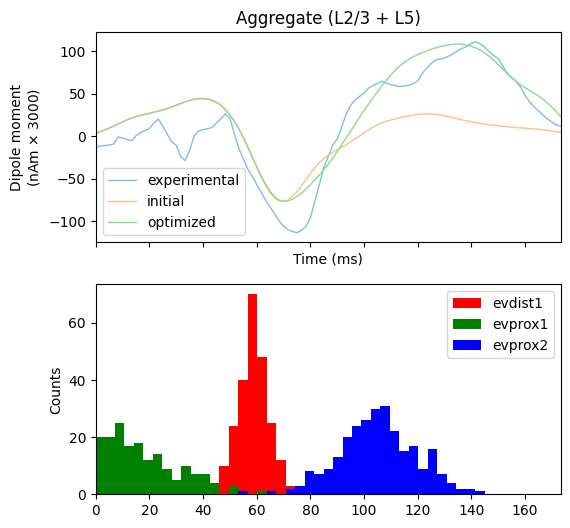

In [8]:
with MPIBackend(n_procs=n_procs, mpi_cmd='mpiexec'):
    opt_dpl = simulate_dipole(optim.net_, tstop=tstop, n_trials=1)[0]
opt_dpl.scale(scale_factor)
opt_dpl.smooth(smooth_window_len)

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(6, 6))

# plot original
exp_dpl.plot(ax=axes[0], layer='agg', show=False, color='tab:blue')
init_dpl.plot(ax=axes[0], layer='agg', show=False, color='tab:orange')
opt_dpl.plot(ax=axes[0], layer='agg', show=False, color='tab:green')
axes[0].legend(['experimental', 'initial', 'optimized'])
optim.net_.cell_response.plot_spikes_hist(ax=axes[1], show=False)
plt.show()

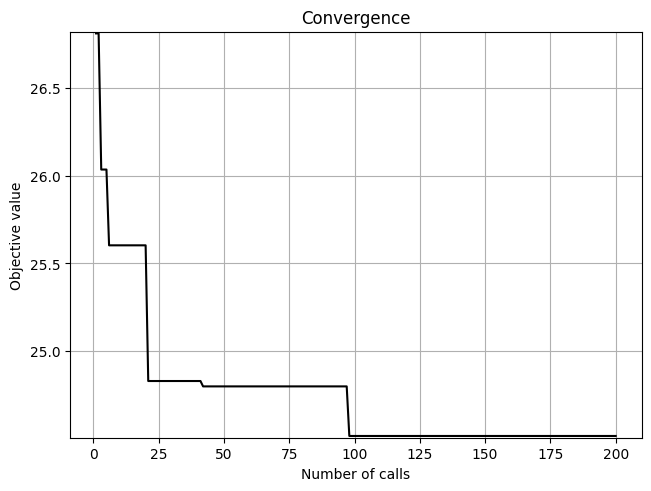

In [9]:
fig1 = optim.plot_convergence(show=False)
plt.show()